   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.6 MB/s eta 0:00:00
Loading data...
Encoding categorical features...

Dataset shape after preprocessing: (33154, 7)
Number of classes: 14
Class distribution:
6     6922
0     6016
5     3421
13    3406
7     3306
2     3190
4     2107
12    1545
3      676
9      585
11     524
1      514
8      480
10     462
Name: count, dtype: int64

Standardizing features...
Removing outliers using Isolation Forest...
Dataset shape after outlier removal: (29839, 7)
Removed 3315 outliers

Training set size: 23871
Test set size: 5968

Training XGBoost with Hyperparameter Tuning...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best XGBoost Parameters: {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 300}
XGBoost Accuracy: 0.6014
XGBoost F1-Score: 0.5852

Training LightGBM with Hyperparameter Tuning...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best LightGBM Parameters: {'learning_rate': 0.1, 'max_depth':

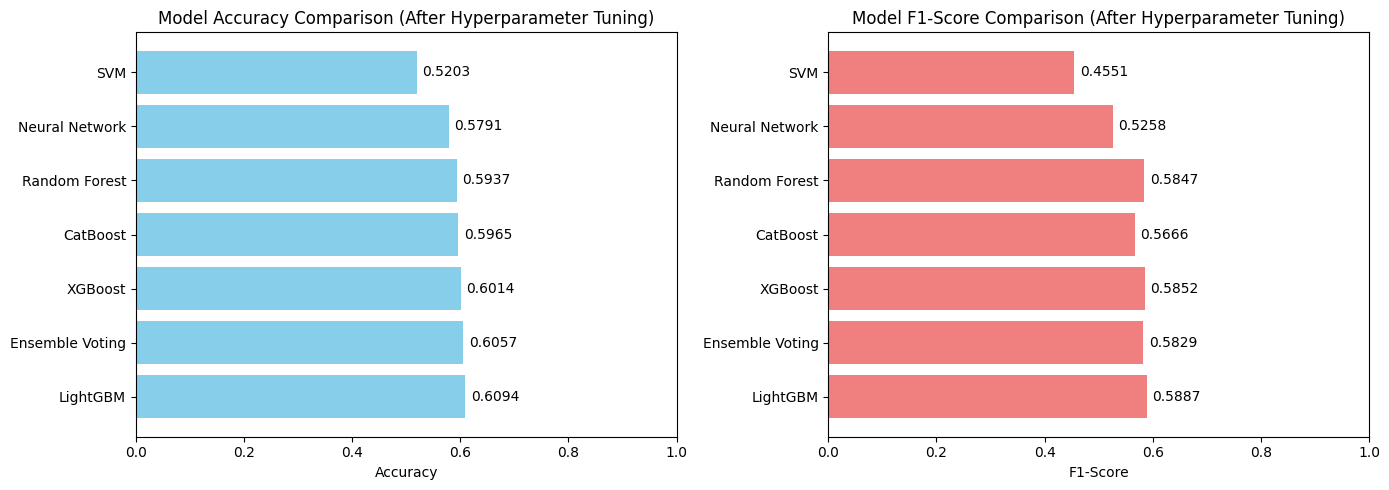

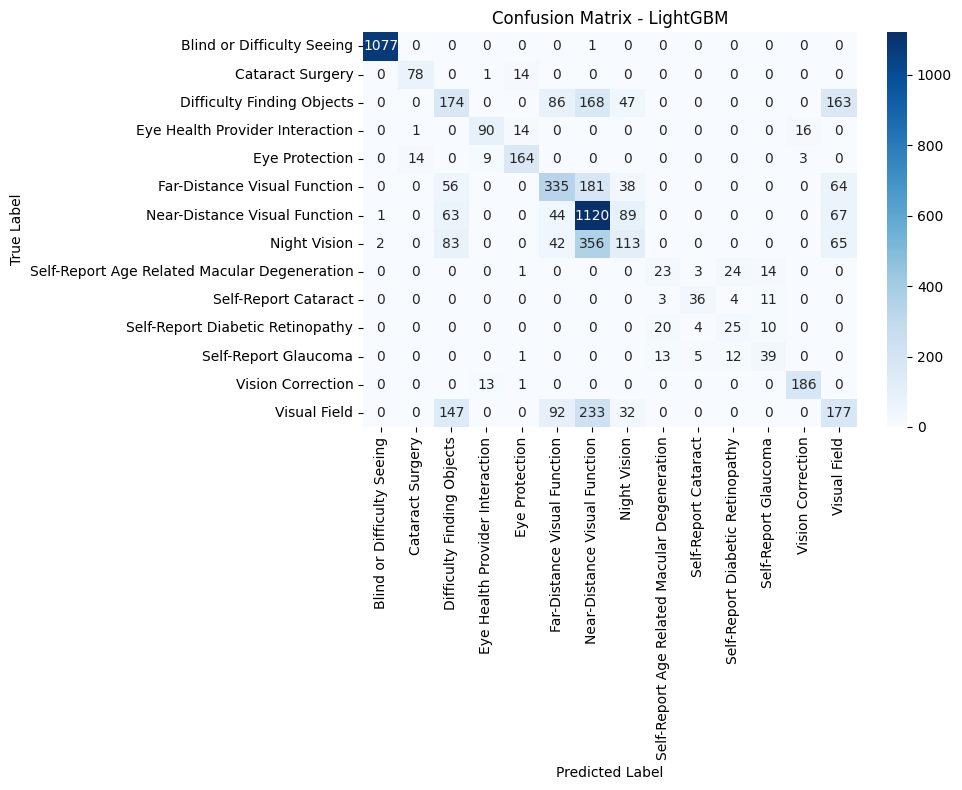

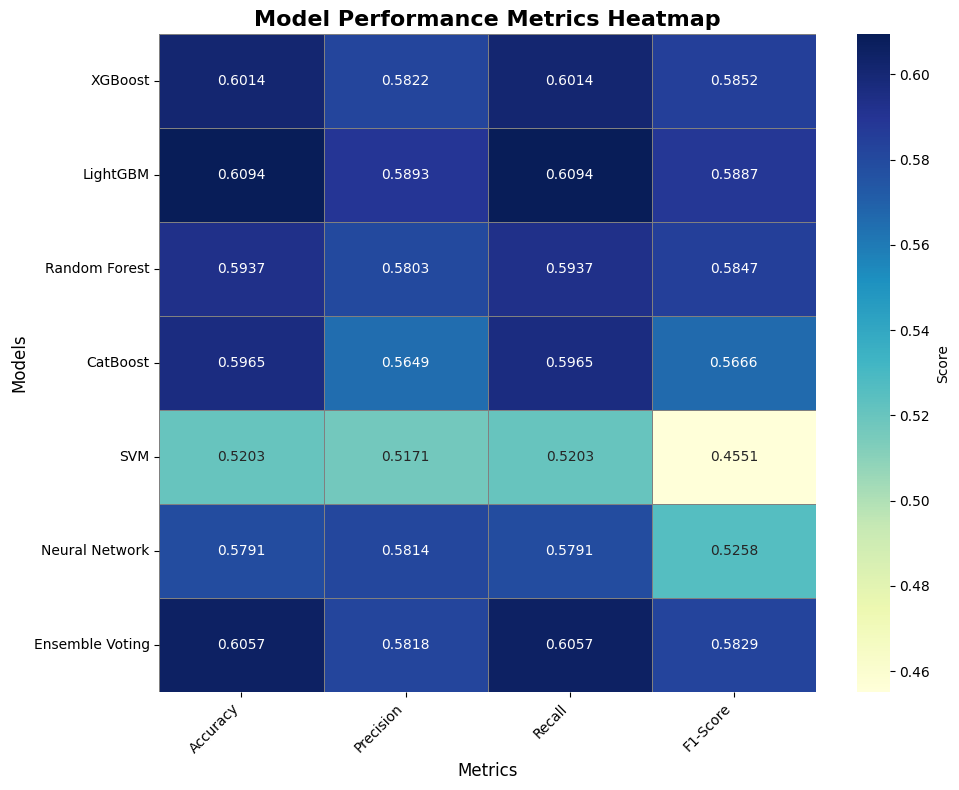

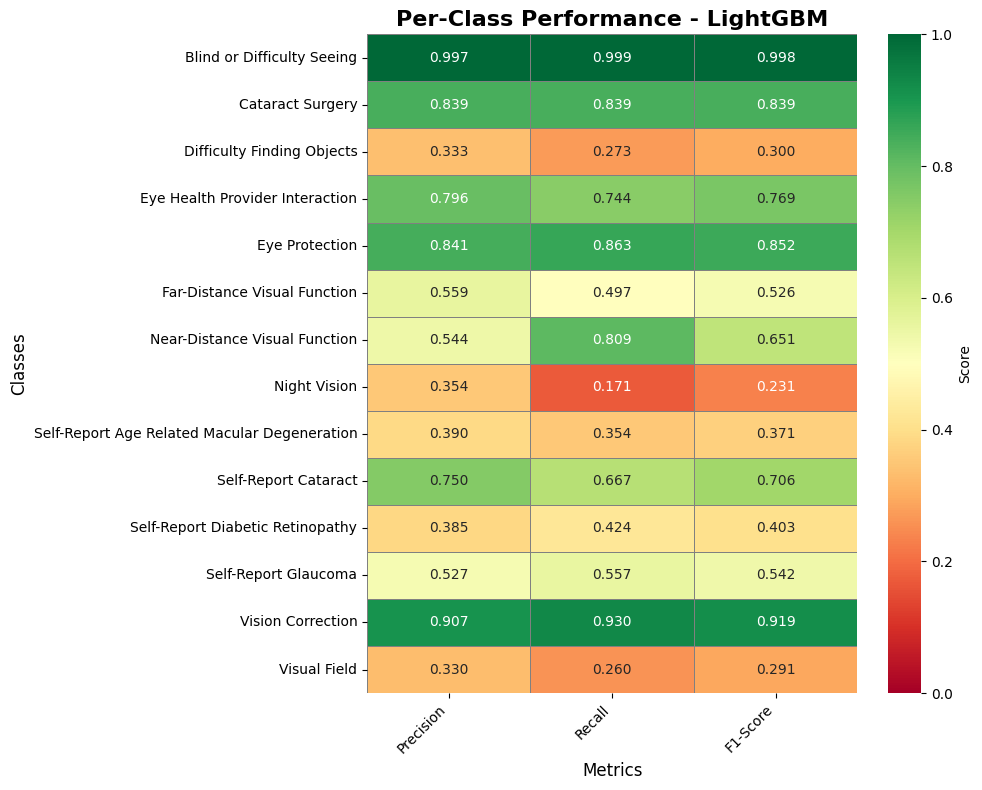


SUMMARY
Total features used: 7
Training samples: 23871
Test samples: 5968
Number of classes: 14

Visualizations saved:
  - model_comparison.png
  - confusion_matrix.png
  - metrics_heatmap.png
  - per_class_heatmap.png


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import IsolationForest, RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                            f1_score, precision_score, recall_score, precision_recall_fscore_support)
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb
!pip install catboost
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# DATA LOADING AND PREPROCESSING
# ============================================================================

print("Loading data...")
data = pd.read_csv('cleaned_dataset.csv')

# Separate target variable
target_column = 'Category'
y = data[target_column].copy()

drop_columns = ['Category', "Question"]
X = data.drop(columns=drop_columns)

# Define categorical columns
categorical_cols = [
    "Topic", "Response", "Data_Value_Type", "AgeCategory", "Sex", "RaceEthnicity"
]

# Fill missing values in categorical columns
print("Encoding categorical features...")
X[categorical_cols] = X[categorical_cols].fillna("Unknown")

# Encode categorical columns
label_encoders = {}
for col in categorical_cols:
    if col in X.columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        label_encoders[col] = le

# Encode target variable
y = y.fillna("Unknown")
target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y)

# Drop any remaining NaNs
valid_indices = X.dropna().index
X = X.loc[valid_indices]
y_encoded = y_encoded[valid_indices]

print(f"\nDataset shape after preprocessing: {X.shape}")
print(f"Number of classes: {len(np.unique(y_encoded))}")
print(f"Class distribution:\n{pd.Series(y_encoded).value_counts()}")

# ============================================================================
# FEATURE SCALING
# ============================================================================

print("\nStandardizing features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ============================================================================
# OUTLIER REMOVAL
# ============================================================================

print("Removing outliers using Isolation Forest...")
isolation_forest = IsolationForest(contamination=0.1, random_state=42)
outliers = isolation_forest.fit_predict(X_scaled)
X_clean = X_scaled[outliers != -1]
y_clean = y_encoded[outliers != -1]

print(f"Dataset shape after outlier removal: {X_clean.shape}")
print(f"Removed {np.sum(outliers == -1)} outliers")

# ============================================================================
# TRAIN-TEST SPLIT
# ============================================================================

X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42, stratify=y_clean
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# ============================================================================
# HYPERPARAMETER TUNING AND CLASSIFICATION MODELS
# ============================================================================

results = {}

# 1. XGBoost with Hyperparameter Tuning
print("\n" + "="*50)
print("Training XGBoost with Hyperparameter Tuning...")
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'learning_rate': [0.05, 0.1, 0.2]
}
xgb_base = xgb.XGBClassifier(random_state=42, n_jobs=-1)
xgb_grid = GridSearchCV(xgb_base, xgb_params, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)
xgb_grid.fit(X_train, y_train)
xgb_model = xgb_grid.best_estimator_
y_pred_xgb = xgb_model.predict(X_test)
results['XGBoost'] = {
    'accuracy': accuracy_score(y_test, y_pred_xgb),
    'f1_score': f1_score(y_test, y_pred_xgb, average='weighted'),
    'predictions': y_pred_xgb,
    'best_params': xgb_grid.best_params_
}
print(f"Best XGBoost Parameters: {xgb_grid.best_params_}")
print(f"XGBoost Accuracy: {results['XGBoost']['accuracy']:.4f}")
print(f"XGBoost F1-Score: {results['XGBoost']['f1_score']:.4f}")

# 2. LightGBM with Hyperparameter Tuning
print("\n" + "="*50)
print("Training LightGBM with Hyperparameter Tuning...")
lgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'learning_rate': [0.05, 0.1, 0.2]
}
lgb_base = lgb.LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1)
lgb_grid = GridSearchCV(lgb_base, lgb_params, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)
lgb_grid.fit(X_train, y_train)
lgb_model = lgb_grid.best_estimator_
y_pred_lgb = lgb_model.predict(X_test)
results['LightGBM'] = {
    'accuracy': accuracy_score(y_test, y_pred_lgb),
    'f1_score': f1_score(y_test, y_pred_lgb, average='weighted'),
    'predictions': y_pred_lgb,
    'best_params': lgb_grid.best_params_
}
print(f"Best LightGBM Parameters: {lgb_grid.best_params_}")
print(f"LightGBM Accuracy: {results['LightGBM']['accuracy']:.4f}")
print(f"LightGBM F1-Score: {results['LightGBM']['f1_score']:.4f}")

# 3. Random Forest with Hyperparameter Tuning
print("\n" + "="*50)
print("Training Random Forest with Hyperparameter Tuning...")
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [15, 20, 25],
    'min_samples_split': [2, 5, 10]
}
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_grid = GridSearchCV(rf_base, rf_params, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)
rf_grid.fit(X_train, y_train)
rf_model = rf_grid.best_estimator_
y_pred_rf = rf_model.predict(X_test)
results['Random Forest'] = {
    'accuracy': accuracy_score(y_test, y_pred_rf),
    'f1_score': f1_score(y_test, y_pred_rf, average='weighted'),
    'predictions': y_pred_rf,
    'best_params': rf_grid.best_params_
}
print(f"Best Random Forest Parameters: {rf_grid.best_params_}")
print(f"Random Forest Accuracy: {results['Random Forest']['accuracy']:.4f}")
print(f"Random Forest F1-Score: {results['Random Forest']['f1_score']:.4f}")

# 4. CatBoost with Hyperparameter Tuning (REPLACEMENT FOR GRADIENT BOOSTING)
print("\n" + "="*50)
print("Training CatBoost with Hyperparameter Tuning...")
# CatBoost is much faster than sklearn's GradientBoosting and often more accurate
catboost_params = {
    'iterations': [100, 200, 300],
    'depth': [6, 8, 10],
    'learning_rate': [0.05, 0.1, 0.2]
}
catboost_base = CatBoostClassifier(random_state=42, verbose=0, thread_count=-1)
catboost_grid = GridSearchCV(catboost_base, catboost_params, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)
catboost_grid.fit(X_train, y_train)
catboost_model = catboost_grid.best_estimator_
y_pred_catboost = catboost_model.predict(X_test)
results['CatBoost'] = {
    'accuracy': accuracy_score(y_test, y_pred_catboost),
    'f1_score': f1_score(y_test, y_pred_catboost, average='weighted'),
    'predictions': y_pred_catboost,
    'best_params': catboost_grid.best_params_
}
print(f"Best CatBoost Parameters: {catboost_grid.best_params_}")
print(f"CatBoost Accuracy: {results['CatBoost']['accuracy']:.4f}")
print(f"CatBoost F1-Score: {results['CatBoost']['f1_score']:.4f}")

# 5. Support Vector Machine with Hyperparameter Tuning (REDUCED SEARCH SPACE)
print("\n" + "="*50)
print("Training SVM with Hyperparameter Tuning...")
# Reduced search space to speed up training
svm_params = {
    'C': [1.0, 10.0],
    'kernel': ['rbf'],
    'gamma': ['scale', 'auto']
}
svm_base = SVC(random_state=42)
svm_grid = GridSearchCV(svm_base, svm_params, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)
svm_grid.fit(X_train, y_train)
svm_model = svm_grid.best_estimator_
y_pred_svm = svm_model.predict(X_test)
results['SVM'] = {
    'accuracy': accuracy_score(y_test, y_pred_svm),
    'f1_score': f1_score(y_test, y_pred_svm, average='weighted'),
    'predictions': y_pred_svm,
    'best_params': svm_grid.best_params_
}
print(f"Best SVM Parameters: {svm_grid.best_params_}")
print(f"SVM Accuracy: {results['SVM']['accuracy']:.4f}")
print(f"SVM F1-Score: {results['SVM']['f1_score']:.4f}")

# 6. Neural Network with Hyperparameter Tuning (REDUCED SEARCH SPACE)
print("\n" + "="*50)
print("Training Neural Network with Hyperparameter Tuning...")
# Reduced search space and iterations to speed up
nn_params = {
    'hidden_layer_sizes': [(100, 50), (100, 100, 50)],
    'alpha': [0.0001, 0.001],
    'learning_rate_init': [0.001, 0.01]
}
nn_base = MLPClassifier(max_iter=300, random_state=42, early_stopping=True)
nn_grid = GridSearchCV(nn_base, nn_params, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)
nn_grid.fit(X_train, y_train)
nn_model = nn_grid.best_estimator_
y_pred_nn = nn_model.predict(X_test)
results['Neural Network'] = {
    'accuracy': accuracy_score(y_test, y_pred_nn),
    'f1_score': f1_score(y_test, y_pred_nn, average='weighted'),
    'predictions': y_pred_nn,
    'best_params': nn_grid.best_params_
}
print(f"Best Neural Network Parameters: {nn_grid.best_params_}")
print(f"Neural Network Accuracy: {results['Neural Network']['accuracy']:.4f}")
print(f"Neural Network F1-Score: {results['Neural Network']['f1_score']:.4f}")

# 7. Ensemble Voting Classifier (using best models from tuning)
print("\n" + "="*50)
print("Training Ensemble (Voting) with tuned models...")
voting_clf = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('lgb', lgb_model),
        ('catboost', catboost_model)
    ],
    voting='soft'
)
voting_clf.fit(X_train, y_train)
y_pred_voting = voting_clf.predict(X_test)
results['Ensemble Voting'] = {
    'accuracy': accuracy_score(y_test, y_pred_voting),
    'f1_score': f1_score(y_test, y_pred_voting, average='weighted'),
    'predictions': y_pred_voting,
    'best_params': 'N/A (Ensemble)'
}
print(f"Ensemble Accuracy: {results['Ensemble Voting']['accuracy']:.4f}")
print(f"Ensemble F1-Score: {results['Ensemble Voting']['f1_score']:.4f}")

# ============================================================================
# RESULTS COMPARISON
# ============================================================================

print("\n" + "="*50)
print("FINAL RESULTS COMPARISON")
print("="*50)

results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'F1-Score': [results[m]['f1_score'] for m in results.keys()]
})
results_df = results_df.sort_values('Accuracy', ascending=False)
print(results_df.to_string(index=False))

# Print best parameters for each model
print("\n" + "="*50)
print("BEST HYPERPARAMETERS FOR EACH MODEL")
print("="*50)
for model_name in results.keys():
    if 'best_params' in results[model_name]:
        print(f"\n{model_name}:")
        print(f"  {results[model_name]['best_params']}")

# Find best model
best_model_name = results_df.iloc[0]['Model']
best_predictions = results[best_model_name]['predictions']

print(f"\nBest Model: {best_model_name}")
print(f"Accuracy: {results_df.iloc[0]['Accuracy']:.4f}")
print(f"F1-Score: {results_df.iloc[0]['F1-Score']:.4f}")

# Detailed classification report for best model
print(f"\n{best_model_name} - Detailed Classification Report:")
print(classification_report(y_test, best_predictions,
                          target_names=[str(c) for c in target_encoder.classes_]))

# ============================================================================
# VISUALIZATIONS
# ============================================================================

# Plot 1: Model Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].barh(results_df['Model'], results_df['Accuracy'], color='skyblue')
axes[0].set_xlabel('Accuracy')
axes[0].set_title('Model Accuracy Comparison (After Hyperparameter Tuning)')
axes[0].set_xlim([0, 1])
for i, v in enumerate(results_df['Accuracy']):
    axes[0].text(v + 0.01, i, f'{v:.4f}', va='center')

axes[1].barh(results_df['Model'], results_df['F1-Score'], color='lightcoral')
axes[1].set_xlabel('F1-Score')
axes[1].set_title('Model F1-Score Comparison (After Hyperparameter Tuning)')
axes[1].set_xlim([0, 1])
for i, v in enumerate(results_df['F1-Score']):
    axes[1].text(v + 0.01, i, f'{v:.4f}', va='center')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 2: Confusion Matrix for Best Model
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, best_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_encoder.classes_,
            yticklabels=target_encoder.classes_)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 3: Comprehensive Metrics Heatmap
metrics_data = []
for model_name in results.keys():
    predictions = results[model_name]['predictions']
    metrics_data.append({
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, predictions),
        'Precision': precision_score(y_test, predictions, average='weighted', zero_division=0),
        'Recall': recall_score(y_test, predictions, average='weighted', zero_division=0),
        'F1-Score': f1_score(y_test, predictions, average='weighted')
    })

metrics_df = pd.DataFrame(metrics_data)
metrics_df = metrics_df.set_index('Model')

plt.figure(figsize=(10, 8))
sns.heatmap(metrics_df, annot=True, fmt='.4f', cmap='YlGnBu',
            cbar_kws={'label': 'Score'}, linewidths=0.5, linecolor='gray')
plt.title('Model Performance Metrics Heatmap', fontsize=16, fontweight='bold')
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Models', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('metrics_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 4: Per-Class Performance Heatmap for Best Model
precision, recall, f1, support = precision_recall_fscore_support(
    y_test, best_predictions, labels=np.unique(y_test), zero_division=0
)

class_metrics = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
}, index=[str(c) for c in target_encoder.inverse_transform(np.unique(y_test))])

plt.figure(figsize=(10, 8))
sns.heatmap(class_metrics[['Precision', 'Recall', 'F1-Score']],
            annot=True, fmt='.3f', cmap='RdYlGn',
            cbar_kws={'label': 'Score'}, linewidths=0.5, linecolor='gray',
            vmin=0, vmax=1)
plt.title(f'Per-Class Performance - {best_model_name}', fontsize=16, fontweight='bold')
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Classes', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('per_class_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*50)
print("SUMMARY")
print("="*50)
print(f"Total features used: {X_clean.shape[1]}")
print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"Number of classes: {len(np.unique(y_encoded))}")
print("\nVisualizations saved:")
print("  - model_comparison.png")
print("  - confusion_matrix.png")
print("  - metrics_heatmap.png")
print("  - per_class_heatmap.png")
print("="*50)

AFTER SMOTE

Loading data...
Encoding categorical features...

Dataset shape after preprocessing: (33154, 7)
Number of classes: 14
Class distribution BEFORE resampling:
6     6922
0     6016
5     3421
13    3406
7     3306
2     3190
4     2107
12    1545
3      676
9      585
11     524
1      514
8      480
10     462
Name: count, dtype: int64

Standardizing features...
Removing outliers using Isolation Forest...
Dataset shape after outlier removal: (29839, 7)
Removed 3315 outliers

Training set size BEFORE resampling: 23871
Test set size: 5968

Handling class imbalance with SMOTE and RandomUnderSampler...
Class distribution in training set BEFORE resampling:
6     5538
0     4311
13    2722
5     2694
7     2645
2     2550
12     801
4      758
3      486
1      374
11     278
8      258
10     238
9      218
Name: count, dtype: int64

Training set size AFTER resampling: 77532
Class distribution in training set AFTER resampling:
0     5538
1     5538
2     5538
3     5538
4     5538
5     5538


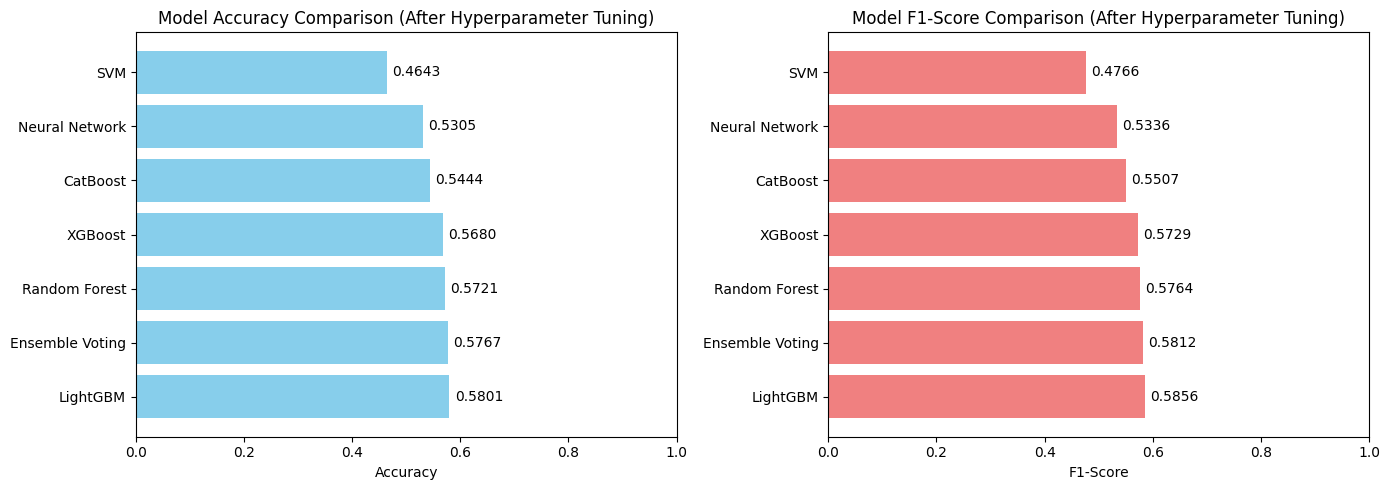

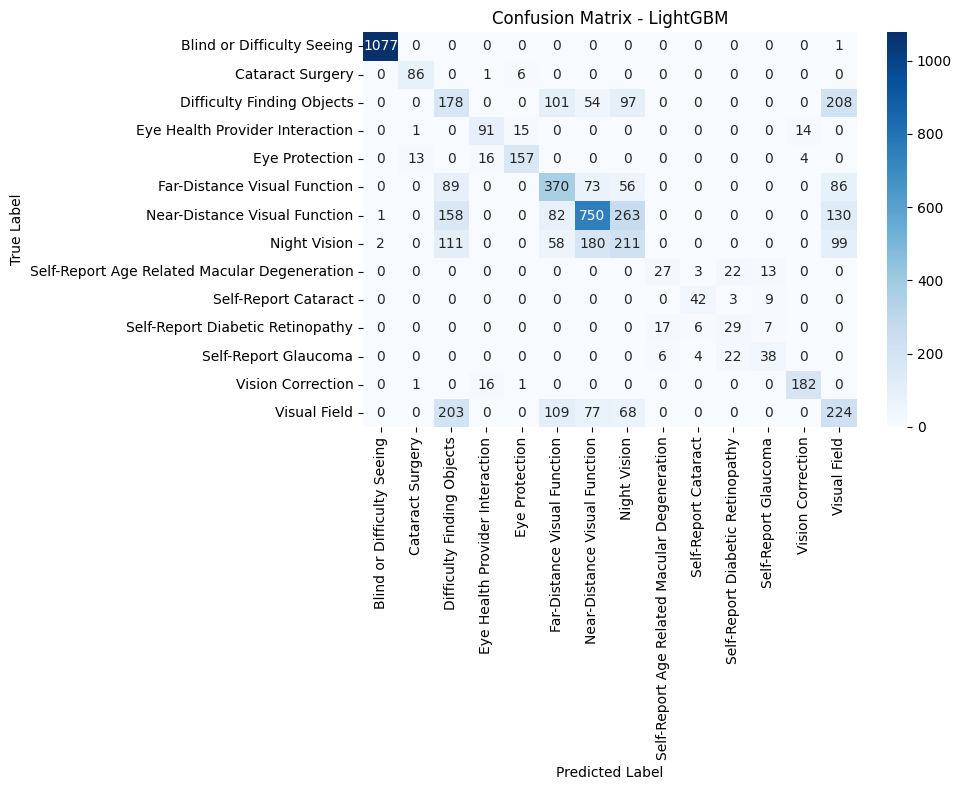

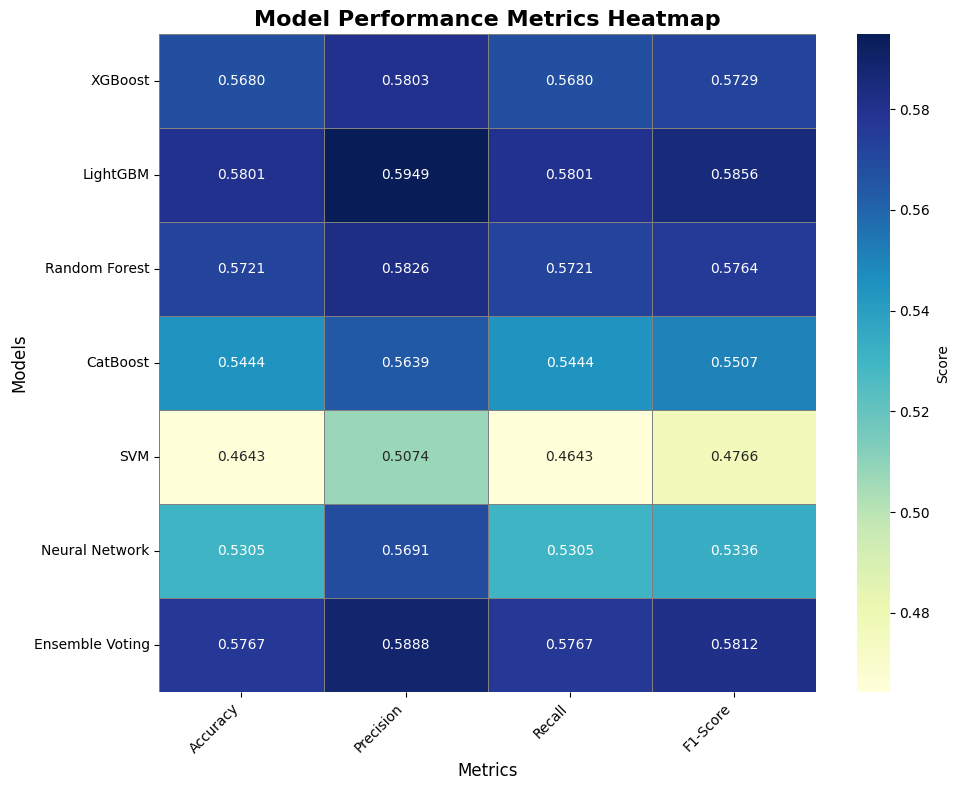

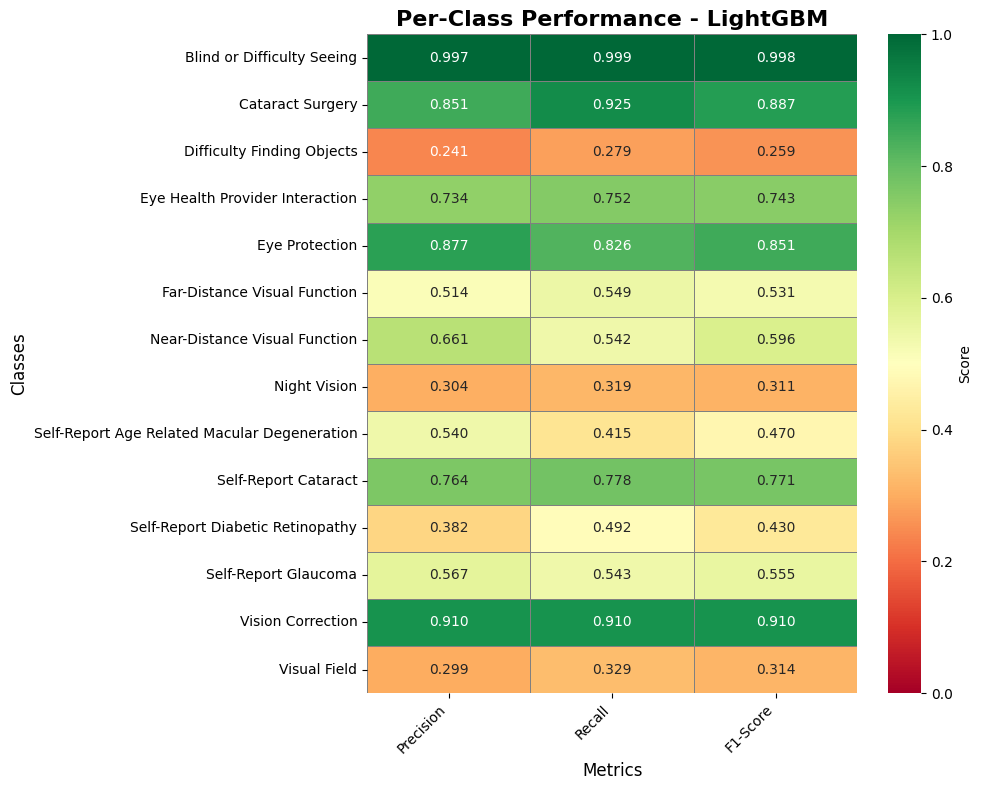


Generating XGBoost training history plots...
Calculating accuracy for 50 iterations...
Note: Using alternative method for accuracy calculation


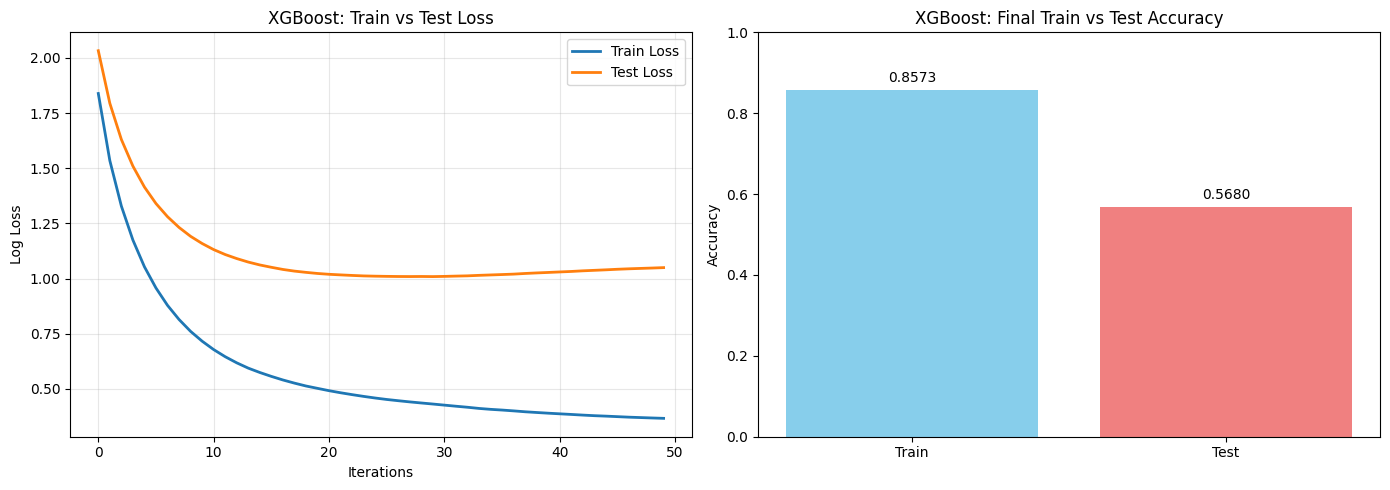

XGBoost training history plots saved successfully.

Generating Neural Network training history plots...


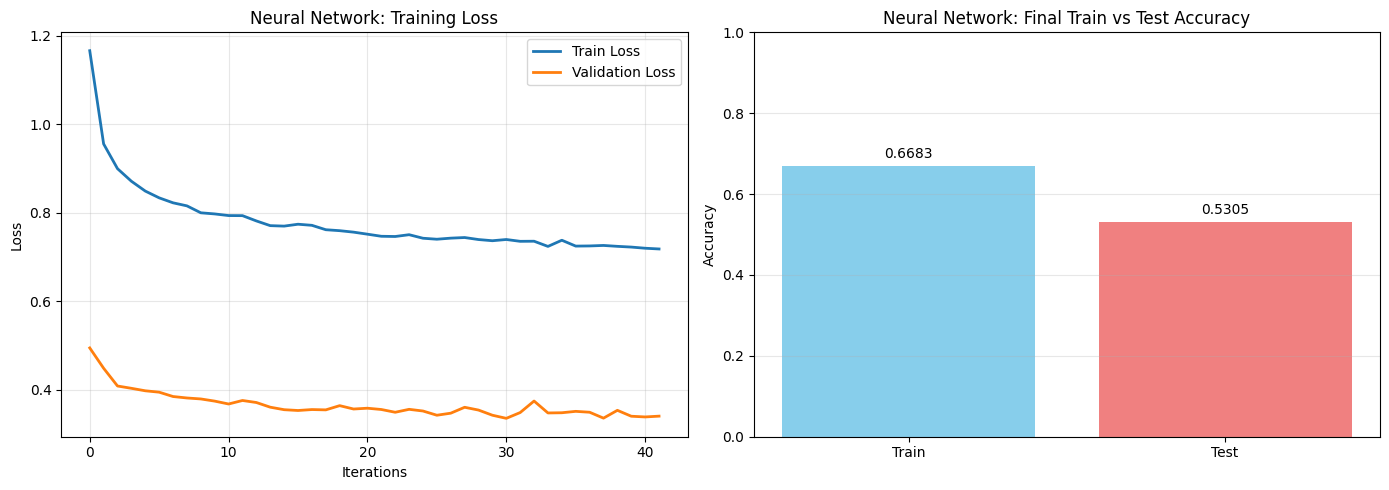

Neural Network training history plots saved successfully.

SUMMARY
Total features used: 7
Training samples (before resampling): 23871
Training samples (after resampling): 77532
Test samples: 5968
Number of classes: 14

Visualizations saved:
  - model_comparison.png
  - confusion_matrix.png
  - metrics_heatmap.png
  - per_class_heatmap.png
  - xgboost_training_history.png
  - neural_network_training_history.png


In [3]:
!pip install imbalanced-learn
!pip install catboost
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import IsolationForest, RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                            f1_score, precision_score, recall_score, precision_recall_fscore_support)
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# DATA LOADING AND PREPROCESSING
# ============================================================================

print("Loading data...")
data = pd.read_csv('cleaned_dataset.csv')

# Separate target variable
target_column = 'Category'
y = data[target_column].copy()

drop_columns = ['Category', "Question"]
X = data.drop(columns=drop_columns)

# Define categorical columns
categorical_cols = [
    "Topic", "Response", "Data_Value_Type", "AgeCategory", "Sex", "RaceEthnicity"
]

# Fill missing values in categorical columns
print("Encoding categorical features...")
X[categorical_cols] = X[categorical_cols].fillna("Unknown")

# Encode categorical columns
label_encoders = {}
for col in categorical_cols:
    if col in X.columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        label_encoders[col] = le

# Encode target variable
y = y.fillna("Unknown")
target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y)

# Drop any remaining NaNs
valid_indices = X.dropna().index
X = X.loc[valid_indices]
y_encoded = y_encoded[valid_indices]

print(f"\nDataset shape after preprocessing: {X.shape}")
print(f"Number of classes: {len(np.unique(y_encoded))}")
print(f"Class distribution BEFORE resampling:\n{pd.Series(y_encoded).value_counts()}")

# ============================================================================
# FEATURE SCALING
# ============================================================================

print("\nStandardizing features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ============================================================================
# OUTLIER REMOVAL
# ============================================================================

print("Removing outliers using Isolation Forest...")
isolation_forest = IsolationForest(contamination=0.1, random_state=42)
outliers = isolation_forest.fit_predict(X_scaled)
X_clean = X_scaled[outliers != -1]
y_clean = y_encoded[outliers != -1]

print(f"Dataset shape after outlier removal: {X_clean.shape}")
print(f"Removed {np.sum(outliers == -1)} outliers")

# ============================================================================
# TRAIN-TEST SPLIT (BEFORE RESAMPLING)
# ============================================================================

X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42, stratify=y_clean
)

print(f"\nTraining set size BEFORE resampling: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# ============================================================================
# HANDLE CLASS IMBALANCE (SMOTE + UNDERSAMPLING)
# ============================================================================

print("\nHandling class imbalance with SMOTE and RandomUnderSampler...")
print(f"Class distribution in training set BEFORE resampling:\n{pd.Series(y_train).value_counts()}")

# Define resampling strategy
# SMOTE for upsampling minority classes, then undersample majority
over = SMOTE(sampling_strategy='auto', random_state=42)
under = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Apply resampling pipeline
X_train_resampled, y_train_resampled = over.fit_resample(X_train, y_train)
X_train_resampled, y_train_resampled = under.fit_resample(X_train_resampled, y_train_resampled)

print(f"\nTraining set size AFTER resampling: {X_train_resampled.shape[0]}")
print(f"Class distribution in training set AFTER resampling:\n{pd.Series(y_train_resampled).value_counts()}")

# ============================================================================
# HYPERPARAMETER TUNING AND CLASSIFICATION MODELS (SIMPLIFIED)
# ============================================================================

results = {}

# 1. XGBoost with Hyperparameter Tuning (max 50 iterations)
print("\n" + "="*50)
print("Training XGBoost with Hyperparameter Tuning...")
xgb_params = {
    'n_estimators': [50],
    'max_depth': [10, 15, 20],
    'learning_rate': [0.05, 0.1, 0.2]
}
xgb_base = xgb.XGBClassifier(random_state=42, n_jobs=-1, eval_metric='mlogloss')
xgb_grid = GridSearchCV(xgb_base, xgb_params, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)
xgb_grid.fit(X_train_resampled, y_train_resampled)
xgb_model = xgb_grid.best_estimator_

# Train again with eval_set to get training history
xgb_model_eval = xgb.XGBClassifier(**xgb_grid.best_params_, random_state=42, n_jobs=-1, eval_metric='mlogloss')
eval_set = [(X_train_resampled, y_train_resampled), (X_test, y_test)]
xgb_model_eval.fit(X_train_resampled, y_train_resampled, eval_set=eval_set, verbose=False)

y_pred_xgb = xgb_model.predict(X_test)
results['XGBoost'] = {
    'accuracy': accuracy_score(y_test, y_pred_xgb),
    'f1_score': f1_score(y_test, y_pred_xgb, average='weighted'),
    'predictions': y_pred_xgb,
    'best_params': xgb_grid.best_params_,
    'model': xgb_model_eval
}
print(f"Best XGBoost Parameters: {xgb_grid.best_params_}")
print(f"XGBoost Accuracy: {results['XGBoost']['accuracy']:.4f}")
print(f"XGBoost F1-Score: {results['XGBoost']['f1_score']:.4f}")

# 2. LightGBM with Hyperparameter Tuning (max 50 iterations)
print("\n" + "="*50)
print("Training LightGBM with Hyperparameter Tuning...")
lgb_params = {
    'n_estimators': [50],
    'max_depth': [10, 15, 20],
    'learning_rate': [0.05, 0.1, 0.2]
}
lgb_base = lgb.LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1)
lgb_grid = GridSearchCV(lgb_base, lgb_params, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)
lgb_grid.fit(X_train_resampled, y_train_resampled)
lgb_model = lgb_grid.best_estimator_

# Train again with eval_set
lgb_model_eval = lgb.LGBMClassifier(**lgb_grid.best_params_, random_state=42, n_jobs=-1, verbose=-1)
lgb_model_eval.fit(X_train_resampled, y_train_resampled,
                   eval_set=[(X_train_resampled, y_train_resampled), (X_test, y_test)])

y_pred_lgb = lgb_model.predict(X_test)
results['LightGBM'] = {
    'accuracy': accuracy_score(y_test, y_pred_lgb),
    'f1_score': f1_score(y_test, y_pred_lgb, average='weighted'),
    'predictions': y_pred_lgb,
    'best_params': lgb_grid.best_params_,
    'model': lgb_model_eval
}
print(f"Best LightGBM Parameters: {lgb_grid.best_params_}")
print(f"LightGBM Accuracy: {results['LightGBM']['accuracy']:.4f}")
print(f"LightGBM F1-Score: {results['LightGBM']['f1_score']:.4f}")

# 3. Random Forest with Hyperparameter Tuning (max 50 trees)
print("\n" + "="*50)
print("Training Random Forest with Hyperparameter Tuning...")
rf_params = {
    'n_estimators': [50],
    'max_depth': [15, 20, 25],
    'min_samples_split': [2, 5, 10]
}
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_grid = GridSearchCV(rf_base, rf_params, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)
rf_grid.fit(X_train_resampled, y_train_resampled)
rf_model = rf_grid.best_estimator_
y_pred_rf = rf_model.predict(X_test)
results['Random Forest'] = {
    'accuracy': accuracy_score(y_test, y_pred_rf),
    'f1_score': f1_score(y_test, y_pred_rf, average='weighted'),
    'predictions': y_pred_rf,
    'best_params': rf_grid.best_params_,
    'model': rf_model
}
print(f"Best Random Forest Parameters: {rf_grid.best_params_}")
print(f"Random Forest Accuracy: {results['Random Forest']['accuracy']:.4f}")
print(f"Random Forest F1-Score: {results['Random Forest']['f1_score']:.4f}")

# 4. CatBoost with Hyperparameter Tuning (max 50 iterations)
print("\n" + "="*50)
print("Training CatBoost with Hyperparameter Tuning...")
catboost_params = {
    'iterations': [50],
    'depth': [6, 8, 10],
    'learning_rate': [0.05, 0.1, 0.2]
}
catboost_base = CatBoostClassifier(random_state=42, verbose=0, thread_count=-1)
catboost_grid = GridSearchCV(catboost_base, catboost_params, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)
catboost_grid.fit(X_train_resampled, y_train_resampled)
catboost_model = catboost_grid.best_estimator_
y_pred_catboost = catboost_model.predict(X_test)
results['CatBoost'] = {
    'accuracy': accuracy_score(y_test, y_pred_catboost),
    'f1_score': f1_score(y_test, y_pred_catboost, average='weighted'),
    'predictions': y_pred_catboost,
    'best_params': catboost_grid.best_params_,
    'model': catboost_model
}
print(f"Best CatBoost Parameters: {catboost_grid.best_params_}")
print(f"CatBoost Accuracy: {results['CatBoost']['accuracy']:.4f}")
print(f"CatBoost F1-Score: {results['CatBoost']['f1_score']:.4f}")

# 5. Support Vector Machine with Hyperparameter Tuning (REDUCED SEARCH SPACE)
print("\n" + "="*50)
print("Training SVM with Hyperparameter Tuning...")
svm_params = {
    'C': [1.0, 10.0],
    'kernel': ['rbf'],
    'gamma': ['scale', 'auto']
}
svm_base = SVC(random_state=42)
svm_grid = GridSearchCV(svm_base, svm_params, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)
svm_grid.fit(X_train_resampled, y_train_resampled)
svm_model = svm_grid.best_estimator_
y_pred_svm = svm_model.predict(X_test)
results['SVM'] = {
    'accuracy': accuracy_score(y_test, y_pred_svm),
    'f1_score': f1_score(y_test, y_pred_svm, average='weighted'),
    'predictions': y_pred_svm,
    'best_params': svm_grid.best_params_,
    'model': svm_model
}
print(f"Best SVM Parameters: {svm_grid.best_params_}")
print(f"SVM Accuracy: {results['SVM']['accuracy']:.4f}")
print(f"SVM F1-Score: {results['SVM']['f1_score']:.4f}")

# 6. Neural Network with Hyperparameter Tuning (max 50 iterations, REDUCED SEARCH SPACE)
print("\n" + "="*50)
print("Training Neural Network with Hyperparameter Tuning...")
nn_params = {
    'hidden_layer_sizes': [(100, 50), (100, 100, 50)],
    'alpha': [0.0001, 0.001],
    'learning_rate_init': [0.001, 0.01]
}
nn_base = MLPClassifier(max_iter=50, random_state=42, early_stopping=True, validation_fraction=0.2)
nn_grid = GridSearchCV(nn_base, nn_params, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)
nn_grid.fit(X_train_resampled, y_train_resampled)
nn_model = nn_grid.best_estimator_
y_pred_nn = nn_model.predict(X_test)
results['Neural Network'] = {
    'accuracy': accuracy_score(y_test, y_pred_nn),
    'f1_score': f1_score(y_test, y_pred_nn, average='weighted'),
    'predictions': y_pred_nn,
    'best_params': nn_grid.best_params_,
    'model': nn_model
}
print(f"Best Neural Network Parameters: {nn_grid.best_params_}")
print(f"Neural Network Accuracy: {results['Neural Network']['accuracy']:.4f}")
print(f"Neural Network F1-Score: {results['Neural Network']['f1_score']:.4f}")

# 7. Ensemble Voting Classifier (using best models from tuning)
print("\n" + "="*50)
print("Training Ensemble (Voting) with tuned models...")
voting_clf = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('lgb', lgb_model),
        ('catboost', catboost_model)
    ],
    voting='soft'
)
voting_clf.fit(X_train_resampled, y_train_resampled)
y_pred_voting = voting_clf.predict(X_test)
results['Ensemble Voting'] = {
    'accuracy': accuracy_score(y_test, y_pred_voting),
    'f1_score': f1_score(y_test, y_pred_voting, average='weighted'),
    'predictions': y_pred_voting,
    'best_params': 'N/A (Ensemble)',
    'model': voting_clf
}
print(f"Ensemble Accuracy: {results['Ensemble Voting']['accuracy']:.4f}")
print(f"Ensemble F1-Score: {results['Ensemble Voting']['f1_score']:.4f}")

# ============================================================================
# RESULTS COMPARISON
# ============================================================================

print("\n" + "="*50)
print("FINAL RESULTS COMPARISON")
print("="*50)

results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'F1-Score': [results[m]['f1_score'] for m in results.keys()]
})
results_df = results_df.sort_values('Accuracy', ascending=False)
print(results_df.to_string(index=False))

# Print best parameters for each model
print("\n" + "="*50)
print("BEST HYPERPARAMETERS FOR EACH MODEL")
print("="*50)
for model_name in results.keys():
    if 'best_params' in results[model_name]:
        print(f"\n{model_name}:")
        print(f"  {results[model_name]['best_params']}")

# Find best model
best_model_name = results_df.iloc[0]['Model']
best_predictions = results[best_model_name]['predictions']

print(f"\nBest Model: {best_model_name}")
print(f"Accuracy: {results_df.iloc[0]['Accuracy']:.4f}")
print(f"F1-Score: {results_df.iloc[0]['F1-Score']:.4f}")

# Detailed classification report for best model
print(f"\n{best_model_name} - Detailed Classification Report:")
print(classification_report(y_test, best_predictions,
                          target_names=[str(c) for c in target_encoder.classes_]))

# ============================================================================
# VISUALIZATIONS
# ============================================================================

# Plot 1: Model Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].barh(results_df['Model'], results_df['Accuracy'], color='skyblue')
axes[0].set_xlabel('Accuracy')
axes[0].set_title('Model Accuracy Comparison (After Hyperparameter Tuning)')
axes[0].set_xlim([0, 1])
for i, v in enumerate(results_df['Accuracy']):
    axes[0].text(v + 0.01, i, f'{v:.4f}', va='center')

axes[1].barh(results_df['Model'], results_df['F1-Score'], color='lightcoral')
axes[1].set_xlabel('F1-Score')
axes[1].set_title('Model F1-Score Comparison (After Hyperparameter Tuning)')
axes[1].set_xlim([0, 1])
for i, v in enumerate(results_df['F1-Score']):
    axes[1].text(v + 0.01, i, f'{v:.4f}', va='center')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 2: Confusion Matrix for Best Model
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, best_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_encoder.classes_,
            yticklabels=target_encoder.classes_)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 3: Comprehensive Metrics Heatmap
metrics_data = []
for model_name in results.keys():
    predictions = results[model_name]['predictions']
    metrics_data.append({
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, predictions),
        'Precision': precision_score(y_test, predictions, average='weighted', zero_division=0),
        'Recall': recall_score(y_test, predictions, average='weighted', zero_division=0),
        'F1-Score': f1_score(y_test, predictions, average='weighted')
    })

metrics_df = pd.DataFrame(metrics_data)
metrics_df = metrics_df.set_index('Model')

plt.figure(figsize=(10, 8))
sns.heatmap(metrics_df, annot=True, fmt='.4f', cmap='YlGnBu',
            cbar_kws={'label': 'Score'}, linewidths=0.5, linecolor='gray')
plt.title('Model Performance Metrics Heatmap', fontsize=16, fontweight='bold')
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Models', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('metrics_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 4: Per-Class Performance Heatmap for Best Model
precision, recall, f1, support = precision_recall_fscore_support(
    y_test, best_predictions, labels=np.unique(y_test), zero_division=0
)

class_metrics = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
}, index=[str(c) for c in target_encoder.inverse_transform(np.unique(y_test))])

plt.figure(figsize=(10, 8))
sns.heatmap(class_metrics[['Precision', 'Recall', 'F1-Score']],
            annot=True, fmt='.3f', cmap='RdYlGn',
            cbar_kws={'label': 'Score'}, linewidths=0.5, linecolor='gray',
            vmin=0, vmax=1)
plt.title(f'Per-Class Performance - {best_model_name}', fontsize=16, fontweight='bold')
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Classes', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('per_class_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 5: Training History for XGBoost (Loss and Accuracy)
print("\nGenerating XGBoost training history plots...")
try:
    evals_result = results['XGBoost']['model'].evals_result()

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Loss plot
    axes[0].plot(evals_result['validation_0']['mlogloss'], label='Train Loss', linewidth=2)
    axes[0].plot(evals_result['validation_1']['mlogloss'], label='Test Loss', linewidth=2)
    axes[0].set_xlabel('Iterations')
    axes[0].set_ylabel('Log Loss')
    axes[0].set_title('XGBoost: Train vs Test Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Accuracy plot - using ntree_limit parameter instead of creating new models
    train_acc = []
    test_acc = []
    n_iterations = len(evals_result['validation_0']['mlogloss'])
    print(f"Calculating accuracy for {n_iterations} iterations...")

    xgb_full_model = results['XGBoost']['model']
    for i in range(1, n_iterations + 1):
        try:
            # Use ntree_limit to predict with only first i trees
            y_train_pred = xgb_full_model.predict(X_train_resampled, ntree_limit=i)
            y_test_pred = xgb_full_model.predict(X_test, ntree_limit=i)
            train_acc.append(accuracy_score(y_train_resampled, y_train_pred))
            test_acc.append(accuracy_score(y_test, y_test_pred))
        except Exception as iter_err:
            print(f"Note: Using alternative method for accuracy calculation")
            # If ntree_limit doesn't work, just show the loss plot
            break

    if len(train_acc) > 0:
        axes[1].plot(range(1, len(train_acc) + 1), train_acc, label='Train Accuracy', linewidth=2)
        axes[1].plot(range(1, len(test_acc) + 1), test_acc, label='Test Accuracy', linewidth=2)
        axes[1].set_xlabel('Iterations')
        axes[1].set_ylabel('Accuracy')
        axes[1].set_title('XGBoost: Train vs Test Accuracy')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
    else:
        # If we can't generate iteration-wise accuracy, just show final accuracy
        final_train_acc = accuracy_score(y_train_resampled, xgb_full_model.predict(X_train_resampled))
        final_test_acc = results['XGBoost']['accuracy']
        axes[1].bar(['Train', 'Test'], [final_train_acc, final_test_acc], color=['skyblue', 'lightcoral'])
        axes[1].set_ylabel('Accuracy')
        axes[1].set_title('XGBoost: Final Train vs Test Accuracy')
        axes[1].set_ylim([0, 1])
        for i, v in enumerate([final_train_acc, final_test_acc]):
            axes[1].text(i, v + 0.02, f'{v:.4f}', ha='center')

    plt.tight_layout()
    plt.savefig('xgboost_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("XGBoost training history plots saved successfully.")
except Exception as e:
    print(f"Could not generate XGBoost training history: {e}")
    print("Continuing with other visualizations...")

# Plot 6: Training History for Neural Network
print("\nGenerating Neural Network training history plots...")
try:
    nn_model = results['Neural Network']['model']

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Loss plot
    if hasattr(nn_model, 'loss_curve_') and len(nn_model.loss_curve_) > 0:
        axes[0].plot(nn_model.loss_curve_, label='Train Loss', linewidth=2)

        # Add validation loss if available
        if hasattr(nn_model, 'validation_scores_') and len(nn_model.validation_scores_) > 0:
            # Convert validation scores to approximate loss (1 - score)
            val_loss = [1 - score for score in nn_model.validation_scores_]
            axes[0].plot(val_loss, label='Validation Loss', linewidth=2)

        axes[0].set_xlabel('Iterations')
        axes[0].set_ylabel('Loss')
        axes[0].set_title('Neural Network: Training Loss')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
    else:
        axes[0].text(0.5, 0.5, 'Loss curve unavailable',
                    ha='center', va='center', transform=axes[0].transAxes)

    # Accuracy plot - show final train vs test accuracy instead of iteration-wise
    # (retraining at each iteration is too slow and error-prone)
    if hasattr(nn_model, 'loss_curve_') and len(nn_model.loss_curve_) > 0:
        final_train_acc = accuracy_score(y_train_resampled, nn_model.predict(X_train_resampled))
        final_test_acc = results['Neural Network']['accuracy']

        axes[1].bar(['Train', 'Test'], [final_train_acc, final_test_acc], color=['skyblue', 'lightcoral'])
        axes[1].set_ylabel('Accuracy')
        axes[1].set_title('Neural Network: Final Train vs Test Accuracy')
        axes[1].set_ylim([0, 1])
        for i, v in enumerate([final_train_acc, final_test_acc]):
            axes[1].text(i, v + 0.02, f'{v:.4f}', ha='center')
        axes[1].grid(True, alpha=0.3, axis='y')
    else:
        axes[1].text(0.5, 0.5, 'Accuracy plot unavailable',
                    ha='center', va='center', transform=axes[1].transAxes)

    plt.tight_layout()
    plt.savefig('neural_network_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Neural Network training history plots saved successfully.")
except Exception as e:
    print(f"Could not generate Neural Network training history: {e}")
    print("Continuing with summary...")


print("\n" + "="*50)
print("SUMMARY")
print("="*50)
print(f"Total features used: {X_clean.shape[1]}")
print(f"Training samples (before resampling): {X_train.shape[0]}")
print(f"Training samples (after resampling): {X_train_resampled.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"Number of classes: {len(np.unique(y_encoded))}")
print("\nVisualizations saved:")
print("  - model_comparison.png")
print("  - confusion_matrix.png")
print("  - metrics_heatmap.png")
print("  - per_class_heatmap.png")
print("  - xgboost_training_history.png")
print("  - neural_network_training_history.png")
print("="*50)

Simpler models

Loading data...
Encoding categorical features...

Dataset shape after preprocessing: (33154, 7)
Number of classes: 14
Class distribution BEFORE resampling:
6     6922
0     6016
5     3421
13    3406
7     3306
2     3190
4     2107
12    1545
3      676
9      585
11     524
1      514
8      480
10     462
Name: count, dtype: int64

Standardizing features...
Removing outliers using Isolation Forest...
Dataset shape after outlier removal: (29839, 7)
Removed 3315 outliers

Training set size BEFORE resampling: 23871
Test set size: 5968

Handling class imbalance with SMOTE and RandomUnderSampler...
Class distribution in training set BEFORE resampling:
6     5538
0     4311
13    2722
5     2694
7     2645
2     2550
12     801
4      758
3      486
1      374
11     278
8      258
10     238
9      218
Name: count, dtype: int64

Training set size AFTER resampling: 77532
Class distribution in training set AFTER resampling:
0     5538
1     5538
2     5538
3     5538
4     5538
5     5538


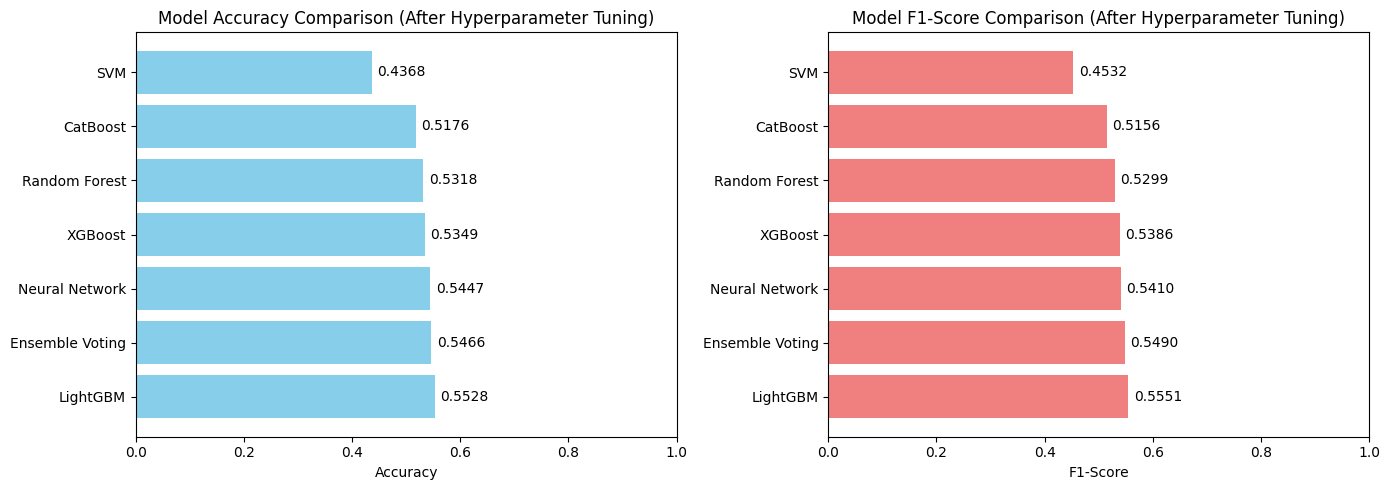

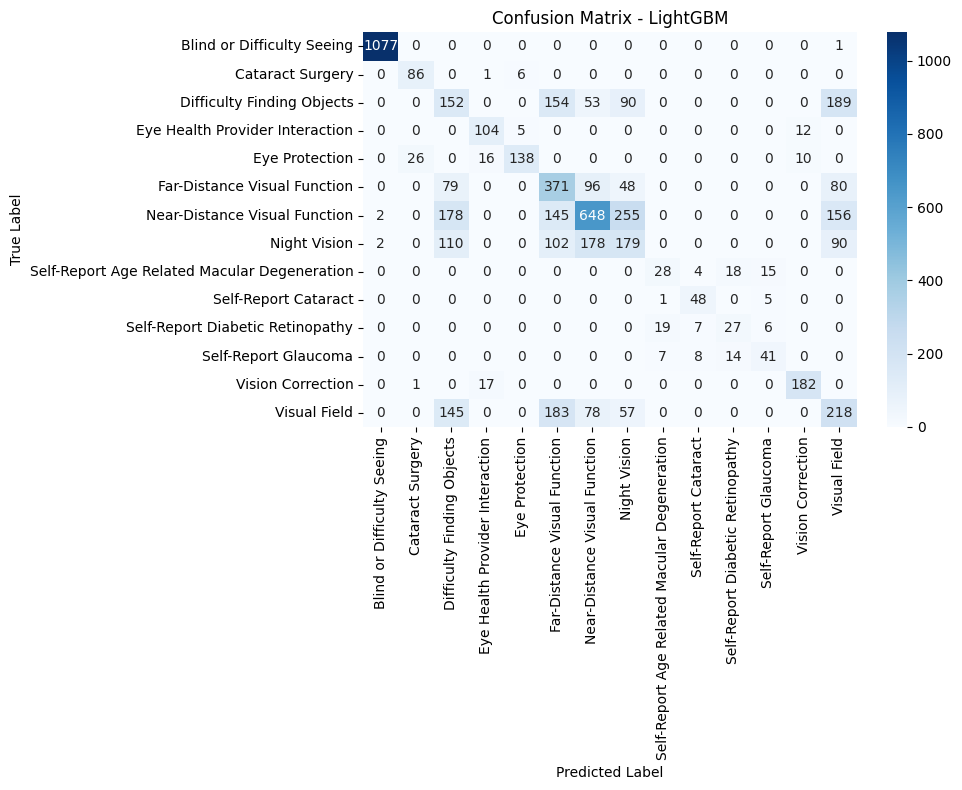

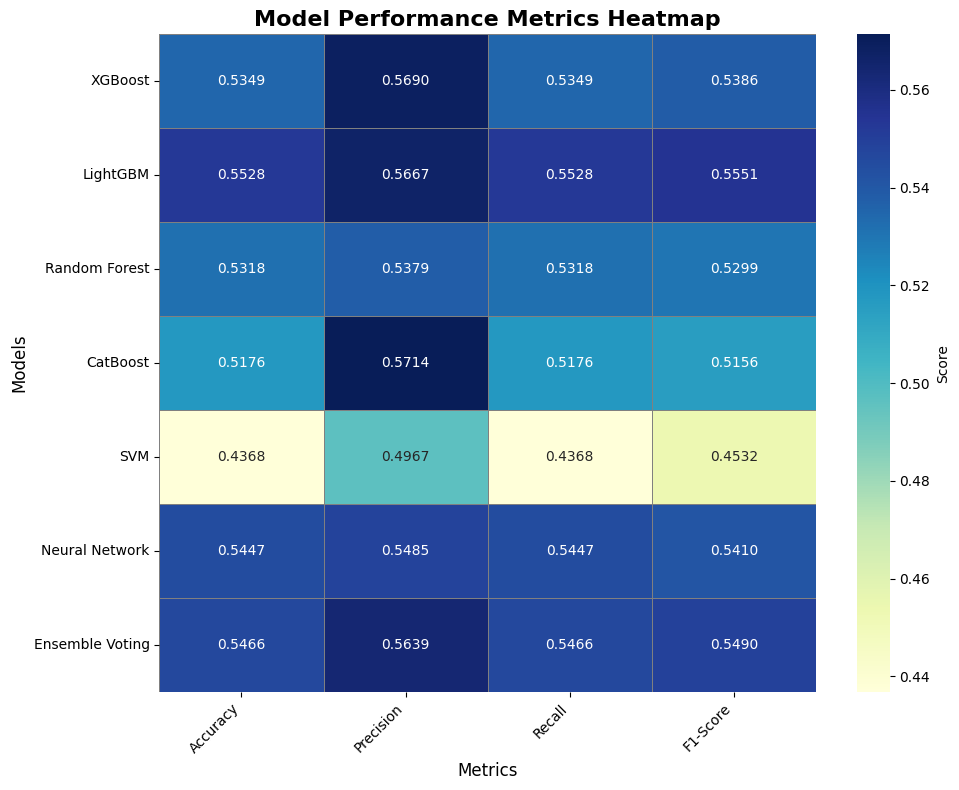

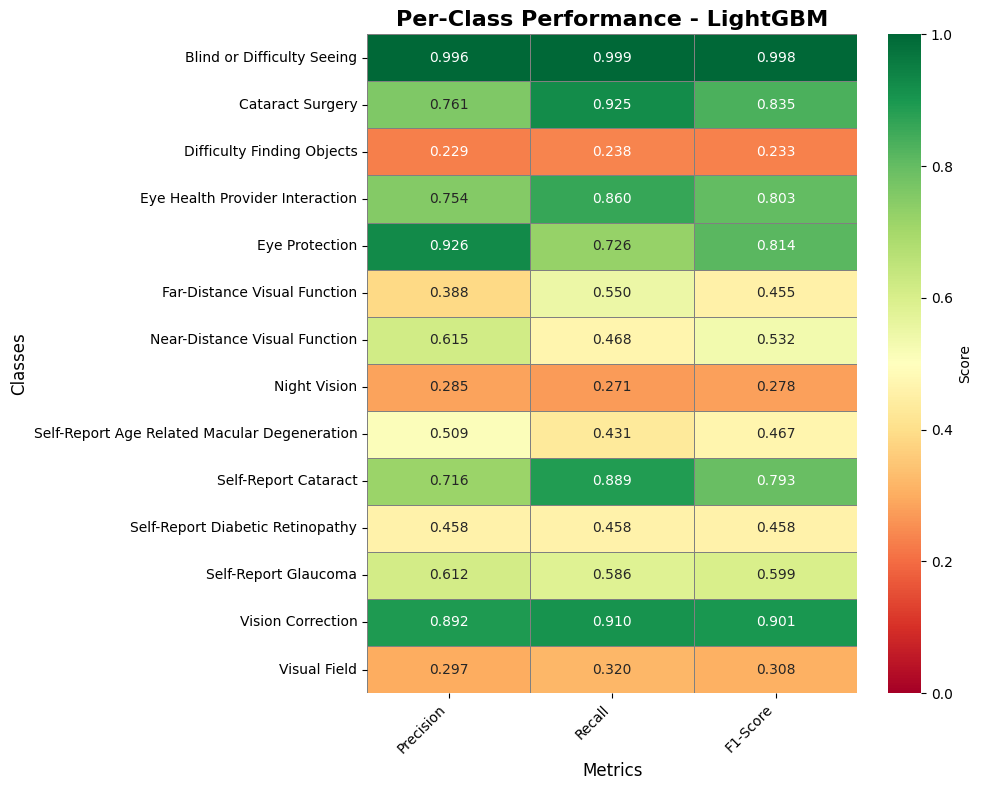


Generating XGBoost training history plots...
Calculating accuracy for 50 iterations...
Note: Using alternative method for accuracy calculation


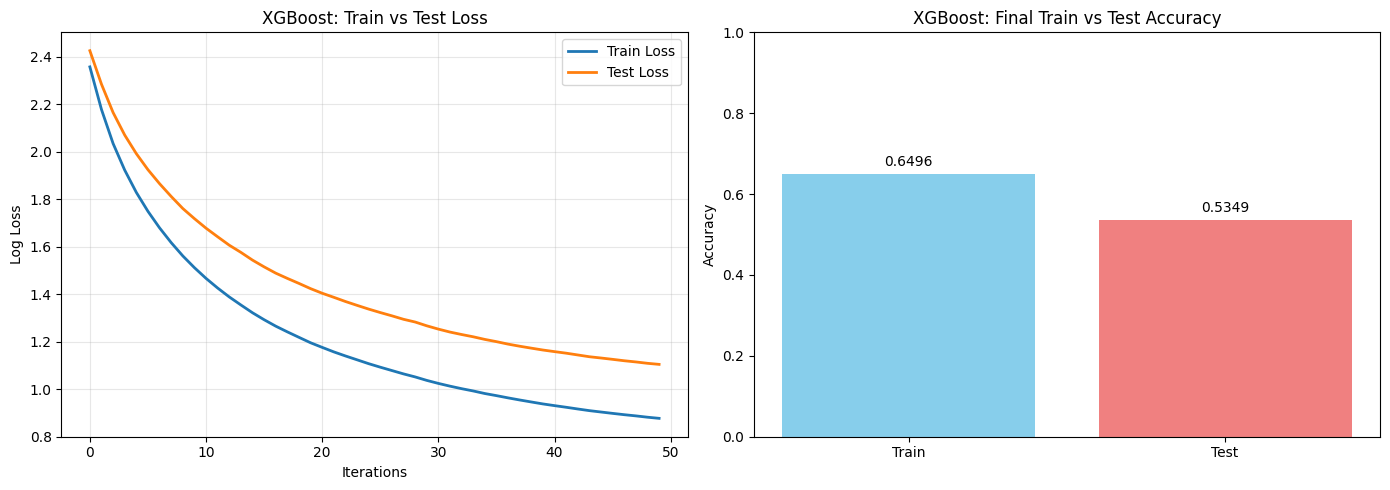

XGBoost training history plots saved successfully.

Generating Neural Network training history plots...


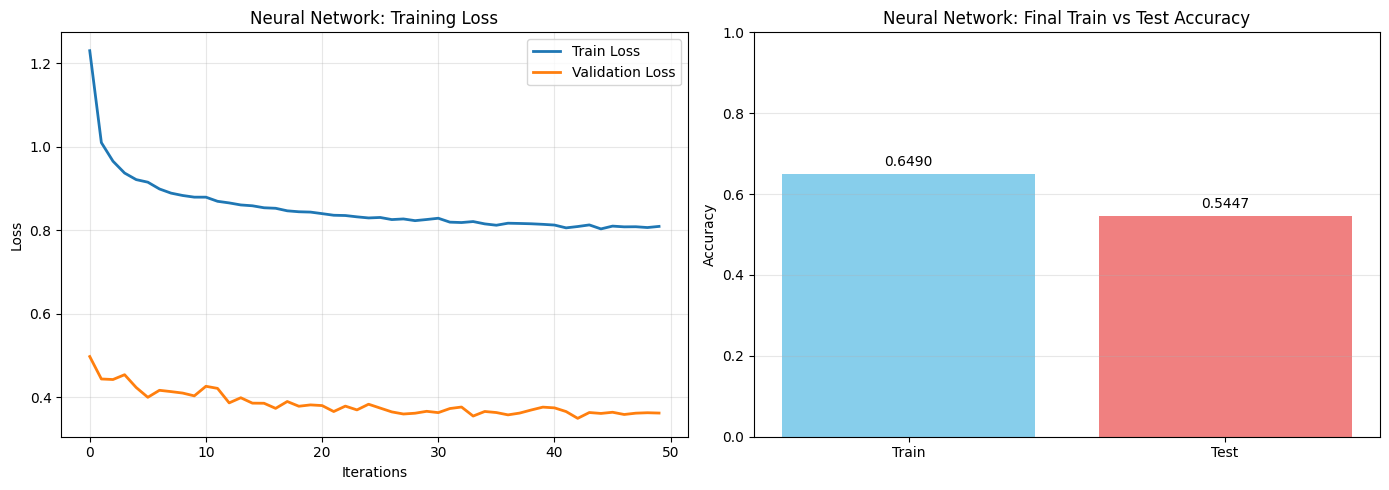

Neural Network training history plots saved successfully.

SUMMARY
Total features used: 7
Training samples (before resampling): 23871
Training samples (after resampling): 77532
Test samples: 5968
Number of classes: 14

Visualizations saved:
  - model_comparison.png
  - confusion_matrix.png
  - metrics_heatmap.png
  - per_class_heatmap.png
  - xgboost_training_history.png
  - neural_network_training_history.png


In [ ]:
!pip install imbalanced-learn
!pip install catboost
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import IsolationForest, RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                            f1_score, precision_score, recall_score, precision_recall_fscore_support)
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# DATA LOADING AND PREPROCESSING
# ============================================================================

print("Loading data...")
data = pd.read_csv('cleaned_dataset.csv')

# Separate target variable
target_column = 'Category'
y = data[target_column].copy()

drop_columns = ['Category', "Question"]
X = data.drop(columns=drop_columns)

# Define categorical columns
categorical_cols = [
    "Topic", "Response", "Data_Value_Type", "AgeCategory", "Sex", "RaceEthnicity"
]

# Fill missing values in categorical columns
print("Encoding categorical features...")
X[categorical_cols] = X[categorical_cols].fillna("Unknown")

# Encode categorical columns
label_encoders = {}
for col in categorical_cols:
    if col in X.columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        label_encoders[col] = le

# Encode target variable
y = y.fillna("Unknown")
target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y)

# Drop any remaining NaNs
valid_indices = X.dropna().index
X = X.loc[valid_indices]
y_encoded = y_encoded[valid_indices]

print(f"\nDataset shape after preprocessing: {X.shape}")
print(f"Number of classes: {len(np.unique(y_encoded))}")
print(f"Class distribution BEFORE resampling:\n{pd.Series(y_encoded).value_counts()}")

# ============================================================================
# FEATURE SCALING
# ============================================================================

print("\nStandardizing features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ============================================================================
# OUTLIER REMOVAL
# ============================================================================

print("Removing outliers using Isolation Forest...")
isolation_forest = IsolationForest(contamination=0.1, random_state=42)
outliers = isolation_forest.fit_predict(X_scaled)
X_clean = X_scaled[outliers != -1]
y_clean = y_encoded[outliers != -1]

print(f"Dataset shape after outlier removal: {X_clean.shape}")
print(f"Removed {np.sum(outliers == -1)} outliers")

# ============================================================================
# TRAIN-TEST SPLIT (BEFORE RESAMPLING)
# ============================================================================

X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42, stratify=y_clean
)

print(f"\nTraining set size BEFORE resampling: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# ============================================================================
# HANDLE CLASS IMBALANCE (SMOTE + UNDERSAMPLING)
# ============================================================================

print("\nHandling class imbalance with SMOTE and RandomUnderSampler...")
print(f"Class distribution in training set BEFORE resampling:\n{pd.Series(y_train).value_counts()}")

# Define resampling strategy
# SMOTE for upsampling minority classes, then undersample majority
over = SMOTE(sampling_strategy='auto', random_state=42)
under = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Apply resampling pipeline
X_train_resampled, y_train_resampled = over.fit_resample(X_train, y_train)
X_train_resampled, y_train_resampled = under.fit_resample(X_train_resampled, y_train_resampled)

print(f"\nTraining set size AFTER resampling: {X_train_resampled.shape[0]}")
print(f"Class distribution in training set AFTER resampling:\n{pd.Series(y_train_resampled).value_counts()}")

# ============================================================================
# HYPERPARAMETER TUNING AND CLASSIFICATION MODELS (SIMPLIFIED)
# ============================================================================

results = {}

# 1. XGBoost with Simplified Hyperparameters (max 50 iterations)
print("\n" + "="*50)
print("Training XGBoost with Hyperparameter Tuning...")
xgb_params = {
    'n_estimators': [30, 50],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1]
}
xgb_base = xgb.XGBClassifier(random_state=42, n_jobs=-1, eval_metric='mlogloss')
xgb_grid = GridSearchCV(xgb_base, xgb_params, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)
xgb_grid.fit(X_train_resampled, y_train_resampled)
xgb_model = xgb_grid.best_estimator_

# Train again with eval_set to get training history
xgb_model_eval = xgb.XGBClassifier(**xgb_grid.best_params_, random_state=42, n_jobs=-1, eval_metric='mlogloss')
eval_set = [(X_train_resampled, y_train_resampled), (X_test, y_test)]
xgb_model_eval.fit(X_train_resampled, y_train_resampled, eval_set=eval_set, verbose=False)

y_pred_xgb = xgb_model.predict(X_test)
results['XGBoost'] = {
    'accuracy': accuracy_score(y_test, y_pred_xgb),
    'f1_score': f1_score(y_test, y_pred_xgb, average='weighted'),
    'predictions': y_pred_xgb,
    'best_params': xgb_grid.best_params_,
    'model': xgb_model_eval
}
print(f"Best XGBoost Parameters: {xgb_grid.best_params_}")
print(f"XGBoost Accuracy: {results['XGBoost']['accuracy']:.4f}")
print(f"XGBoost F1-Score: {results['XGBoost']['f1_score']:.4f}")

# 2. LightGBM with Simplified Hyperparameters (max 50 iterations)
print("\n" + "="*50)
print("Training LightGBM with Hyperparameter Tuning...")
lgb_params = {
    'n_estimators': [30, 50],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1]
}
lgb_base = lgb.LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1)
lgb_grid = GridSearchCV(lgb_base, lgb_params, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)
lgb_grid.fit(X_train_resampled, y_train_resampled)
lgb_model = lgb_grid.best_estimator_

# Train again with eval_set
lgb_model_eval = lgb.LGBMClassifier(**lgb_grid.best_params_, random_state=42, n_jobs=-1, verbose=-1)
lgb_model_eval.fit(X_train_resampled, y_train_resampled,
                   eval_set=[(X_train_resampled, y_train_resampled), (X_test, y_test)])

y_pred_lgb = lgb_model.predict(X_test)
results['LightGBM'] = {
    'accuracy': accuracy_score(y_test, y_pred_lgb),
    'f1_score': f1_score(y_test, y_pred_lgb, average='weighted'),
    'predictions': y_pred_lgb,
    'best_params': lgb_grid.best_params_,
    'model': lgb_model_eval
}
print(f"Best LightGBM Parameters: {lgb_grid.best_params_}")
print(f"LightGBM Accuracy: {results['LightGBM']['accuracy']:.4f}")
print(f"LightGBM F1-Score: {results['LightGBM']['f1_score']:.4f}")

# 3. Random Forest with Simplified Hyperparameters (max 50 trees)
print("\n" + "="*50)
print("Training Random Forest with Hyperparameter Tuning...")
rf_params = {
    'n_estimators': [30, 50],
    'max_depth': [5, 10],
    'min_samples_split': [5, 10]
}
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_grid = GridSearchCV(rf_base, rf_params, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)
rf_grid.fit(X_train_resampled, y_train_resampled)
rf_model = rf_grid.best_estimator_
y_pred_rf = rf_model.predict(X_test)
results['Random Forest'] = {
    'accuracy': accuracy_score(y_test, y_pred_rf),
    'f1_score': f1_score(y_test, y_pred_rf, average='weighted'),
    'predictions': y_pred_rf,
    'best_params': rf_grid.best_params_,
    'model': rf_model
}
print(f"Best Random Forest Parameters: {rf_grid.best_params_}")
print(f"Random Forest Accuracy: {results['Random Forest']['accuracy']:.4f}")
print(f"Random Forest F1-Score: {results['Random Forest']['f1_score']:.4f}")

# 4. CatBoost with Simplified Hyperparameters (max 50 iterations)
print("\n" + "="*50)
print("Training CatBoost with Hyperparameter Tuning...")
catboost_params = {
    'iterations': [30, 50],
    'depth': [3, 5],
    'learning_rate': [0.05, 0.1]
}
catboost_base = CatBoostClassifier(random_state=42, verbose=0, thread_count=-1)
catboost_grid = GridSearchCV(catboost_base, catboost_params, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)
catboost_grid.fit(X_train_resampled, y_train_resampled)
catboost_model = catboost_grid.best_estimator_
y_pred_catboost = catboost_model.predict(X_test)
results['CatBoost'] = {
    'accuracy': accuracy_score(y_test, y_pred_catboost),
    'f1_score': f1_score(y_test, y_pred_catboost, average='weighted'),
    'predictions': y_pred_catboost,
    'best_params': catboost_grid.best_params_,
    'model': catboost_model
}
print(f"Best CatBoost Parameters: {catboost_grid.best_params_}")
print(f"CatBoost Accuracy: {results['CatBoost']['accuracy']:.4f}")
print(f"CatBoost F1-Score: {results['CatBoost']['f1_score']:.4f}")

# 5. Support Vector Machine with Simplified Hyperparameters
print("\n" + "="*50)
print("Training SVM with Hyperparameter Tuning...")
svm_params = {
    'C': [0.1, 1.0],
    'kernel': ['rbf'],
    'gamma': ['scale']
}
svm_base = SVC(random_state=42)
svm_grid = GridSearchCV(svm_base, svm_params, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)
svm_grid.fit(X_train_resampled, y_train_resampled)
svm_model = svm_grid.best_estimator_
y_pred_svm = svm_model.predict(X_test)
results['SVM'] = {
    'accuracy': accuracy_score(y_test, y_pred_svm),
    'f1_score': f1_score(y_test, y_pred_svm, average='weighted'),
    'predictions': y_pred_svm,
    'best_params': svm_grid.best_params_,
    'model': svm_model
}
print(f"Best SVM Parameters: {svm_grid.best_params_}")
print(f"SVM Accuracy: {results['SVM']['accuracy']:.4f}")
print(f"SVM F1-Score: {results['SVM']['f1_score']:.4f}")

# 6. Neural Network with Simplified Hyperparameters (max 50 iterations)
print("\n" + "="*50)
print("Training Neural Network with Hyperparameter Tuning...")
nn_params = {
    'hidden_layer_sizes': [(50,), (50, 25)],
    'alpha': [0.01, 0.1],
    'learning_rate_init': [0.001, 0.01]
}
nn_base = MLPClassifier(max_iter=50, random_state=42, early_stopping=True, validation_fraction=0.2)
nn_grid = GridSearchCV(nn_base, nn_params, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)
nn_grid.fit(X_train_resampled, y_train_resampled)
nn_model = nn_grid.best_estimator_
y_pred_nn = nn_model.predict(X_test)
results['Neural Network'] = {
    'accuracy': accuracy_score(y_test, y_pred_nn),
    'f1_score': f1_score(y_test, y_pred_nn, average='weighted'),
    'predictions': y_pred_nn,
    'best_params': nn_grid.best_params_,
    'model': nn_model
}
print(f"Best Neural Network Parameters: {nn_grid.best_params_}")
print(f"Neural Network Accuracy: {results['Neural Network']['accuracy']:.4f}")
print(f"Neural Network F1-Score: {results['Neural Network']['f1_score']:.4f}")

# 7. Ensemble Voting Classifier (using best models from tuning)
print("\n" + "="*50)
print("Training Ensemble (Voting) with tuned models...")
voting_clf = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('lgb', lgb_model),
        ('catboost', catboost_model)
    ],
    voting='soft'
)
voting_clf.fit(X_train_resampled, y_train_resampled)
y_pred_voting = voting_clf.predict(X_test)
results['Ensemble Voting'] = {
    'accuracy': accuracy_score(y_test, y_pred_voting),
    'f1_score': f1_score(y_test, y_pred_voting, average='weighted'),
    'predictions': y_pred_voting,
    'best_params': 'N/A (Ensemble)',
    'model': voting_clf
}
print(f"Ensemble Accuracy: {results['Ensemble Voting']['accuracy']:.4f}")
print(f"Ensemble F1-Score: {results['Ensemble Voting']['f1_score']:.4f}")

# ============================================================================
# RESULTS COMPARISON
# ============================================================================

print("\n" + "="*50)
print("FINAL RESULTS COMPARISON")
print("="*50)

results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'F1-Score': [results[m]['f1_score'] for m in results.keys()]
})
results_df = results_df.sort_values('Accuracy', ascending=False)
print(results_df.to_string(index=False))

# Print best parameters for each model
print("\n" + "="*50)
print("BEST HYPERPARAMETERS FOR EACH MODEL")
print("="*50)
for model_name in results.keys():
    if 'best_params' in results[model_name]:
        print(f"\n{model_name}:")
        print(f"  {results[model_name]['best_params']}")

# Find best model
best_model_name = results_df.iloc[0]['Model']
best_predictions = results[best_model_name]['predictions']

print(f"\nBest Model: {best_model_name}")
print(f"Accuracy: {results_df.iloc[0]['Accuracy']:.4f}")
print(f"F1-Score: {results_df.iloc[0]['F1-Score']:.4f}")

# Detailed classification report for best model
print(f"\n{best_model_name} - Detailed Classification Report:")
print(classification_report(y_test, best_predictions,
                          target_names=[str(c) for c in target_encoder.classes_]))

# ============================================================================
# VISUALIZATIONS
# ============================================================================

# Plot 1: Model Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].barh(results_df['Model'], results_df['Accuracy'], color='skyblue')
axes[0].set_xlabel('Accuracy')
axes[0].set_title('Model Accuracy Comparison (After Hyperparameter Tuning)')
axes[0].set_xlim([0, 1])
for i, v in enumerate(results_df['Accuracy']):
    axes[0].text(v + 0.01, i, f'{v:.4f}', va='center')

axes[1].barh(results_df['Model'], results_df['F1-Score'], color='lightcoral')
axes[1].set_xlabel('F1-Score')
axes[1].set_title('Model F1-Score Comparison (After Hyperparameter Tuning)')
axes[1].set_xlim([0, 1])
for i, v in enumerate(results_df['F1-Score']):
    axes[1].text(v + 0.01, i, f'{v:.4f}', va='center')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 2: Confusion Matrix for Best Model
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, best_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_encoder.classes_,
            yticklabels=target_encoder.classes_)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 3: Comprehensive Metrics Heatmap
metrics_data = []
for model_name in results.keys():
    predictions = results[model_name]['predictions']
    metrics_data.append({
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, predictions),
        'Precision': precision_score(y_test, predictions, average='weighted', zero_division=0),
        'Recall': recall_score(y_test, predictions, average='weighted', zero_division=0),
        'F1-Score': f1_score(y_test, predictions, average='weighted')
    })

metrics_df = pd.DataFrame(metrics_data)
metrics_df = metrics_df.set_index('Model')

plt.figure(figsize=(10, 8))
sns.heatmap(metrics_df, annot=True, fmt='.4f', cmap='YlGnBu',
            cbar_kws={'label': 'Score'}, linewidths=0.5, linecolor='gray')
plt.title('Model Performance Metrics Heatmap', fontsize=16, fontweight='bold')
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Models', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('metrics_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 4: Per-Class Performance Heatmap for Best Model
precision, recall, f1, support = precision_recall_fscore_support(
    y_test, best_predictions, labels=np.unique(y_test), zero_division=0
)

class_metrics = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
}, index=[str(c) for c in target_encoder.inverse_transform(np.unique(y_test))])

plt.figure(figsize=(10, 8))
sns.heatmap(class_metrics[['Precision', 'Recall', 'F1-Score']],
            annot=True, fmt='.3f', cmap='RdYlGn',
            cbar_kws={'label': 'Score'}, linewidths=0.5, linecolor='gray',
            vmin=0, vmax=1)
plt.title(f'Per-Class Performance - {best_model_name}', fontsize=16, fontweight='bold')
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Classes', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('per_class_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 5: Training History for XGBoost (Loss and Accuracy)
print("\nGenerating XGBoost training history plots...")
try:
    evals_result = results['XGBoost']['model'].evals_result()

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Loss plot
    axes[0].plot(evals_result['validation_0']['mlogloss'], label='Train Loss', linewidth=2)
    axes[0].plot(evals_result['validation_1']['mlogloss'], label='Test Loss', linewidth=2)
    axes[0].set_xlabel('Iterations')
    axes[0].set_ylabel('Log Loss')
    axes[0].set_title('XGBoost: Train vs Test Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Accuracy plot - using ntree_limit parameter instead of creating new models
    train_acc = []
    test_acc = []
    n_iterations = len(evals_result['validation_0']['mlogloss'])
    print(f"Calculating accuracy for {n_iterations} iterations...")

    xgb_full_model = results['XGBoost']['model']
    for i in range(1, n_iterations + 1):
        try:
            # Use ntree_limit to predict with only first i trees
            y_train_pred = xgb_full_model.predict(X_train_resampled, ntree_limit=i)
            y_test_pred = xgb_full_model.predict(X_test, ntree_limit=i)
            train_acc.append(accuracy_score(y_train_resampled, y_train_pred))
            test_acc.append(accuracy_score(y_test, y_test_pred))
        except Exception as iter_err:
            print(f"Note: Using alternative method for accuracy calculation")
            # If ntree_limit doesn't work, just show the loss plot
            break

    if len(train_acc) > 0:
        axes[1].plot(range(1, len(train_acc) + 1), train_acc, label='Train Accuracy', linewidth=2)
        axes[1].plot(range(1, len(test_acc) + 1), test_acc, label='Test Accuracy', linewidth=2)
        axes[1].set_xlabel('Iterations')
        axes[1].set_ylabel('Accuracy')
        axes[1].set_title('XGBoost: Train vs Test Accuracy')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
    else:
        # If we can't generate iteration-wise accuracy, just show final accuracy
        final_train_acc = accuracy_score(y_train_resampled, xgb_full_model.predict(X_train_resampled))
        final_test_acc = results['XGBoost']['accuracy']
        axes[1].bar(['Train', 'Test'], [final_train_acc, final_test_acc], color=['skyblue', 'lightcoral'])
        axes[1].set_ylabel('Accuracy')
        axes[1].set_title('XGBoost: Final Train vs Test Accuracy')
        axes[1].set_ylim([0, 1])
        for i, v in enumerate([final_train_acc, final_test_acc]):
            axes[1].text(i, v + 0.02, f'{v:.4f}', ha='center')

    plt.tight_layout()
    plt.savefig('xgboost_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("XGBoost training history plots saved successfully.")
except Exception as e:
    print(f"Could not generate XGBoost training history: {e}")
    print("Continuing with other visualizations...")

# Plot 6: Training History for Neural Network
print("\nGenerating Neural Network training history plots...")
try:
    nn_model = results['Neural Network']['model']

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Loss plot
    if hasattr(nn_model, 'loss_curve_') and len(nn_model.loss_curve_) > 0:
        axes[0].plot(nn_model.loss_curve_, label='Train Loss', linewidth=2)

        # Add validation loss if available
        if hasattr(nn_model, 'validation_scores_') and len(nn_model.validation_scores_) > 0:
            # Convert validation scores to approximate loss (1 - score)
            val_loss = [1 - score for score in nn_model.validation_scores_]
            axes[0].plot(val_loss, label='Validation Loss', linewidth=2)

        axes[0].set_xlabel('Iterations')
        axes[0].set_ylabel('Loss')
        axes[0].set_title('Neural Network: Training Loss')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
    else:
        axes[0].text(0.5, 0.5, 'Loss curve unavailable',
                    ha='center', va='center', transform=axes[0].transAxes)

    # Accuracy plot - show final train vs test accuracy instead of iteration-wise
    # (retraining at each iteration is too slow and error-prone)
    if hasattr(nn_model, 'loss_curve_') and len(nn_model.loss_curve_) > 0:
        final_train_acc = accuracy_score(y_train_resampled, nn_model.predict(X_train_resampled))
        final_test_acc = results['Neural Network']['accuracy']

        axes[1].bar(['Train', 'Test'], [final_train_acc, final_test_acc], color=['skyblue', 'lightcoral'])
        axes[1].set_ylabel('Accuracy')
        axes[1].set_title('Neural Network: Final Train vs Test Accuracy')
        axes[1].set_ylim([0, 1])
        for i, v in enumerate([final_train_acc, final_test_acc]):
            axes[1].text(i, v + 0.02, f'{v:.4f}', ha='center')
        axes[1].grid(True, alpha=0.3, axis='y')
    else:
        axes[1].text(0.5, 0.5, 'Accuracy plot unavailable',
                    ha='center', va='scenter', transform=axes[1].transAxes)

    plt.tight_layout()
    plt.savefig('neural_network_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Neural Network training history plots saved successfully.")
except Exception as e:
    print(f"Could not generate Neural Network training history: {e}")
    print("Continuing with summary...")

print("\n" + "="*50)
print("SUMMARY")
print("="*50)
print(f"Total features used: {X_clean.shape[1]}")
print(f"Training samples (before resampling): {X_train.shape[0]}")
print(f"Training samples (after resampling): {X_train_resampled.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"Number of classes: {len(np.unique(y_encoded))}")
print("\nVisualizations saved:")
print("  - model_comparison.png")
print("  - confusion_matrix.png")
print("  - metrics_heatmap.png")
print("  - per_class_heatmap.png")
print("  - xgboost_training_history.png")
print("  - neural_network_training_history.png")
print("="*50)